## Spatial and temporal correlation analysis between VIs and SPIs
### We will use the pearsonr and spearmanr functions from SciPy to calculate the correlation between EVI(NDVI) and SPIs in the timeseries for each pixel.

In [1]:
import xarray as xr
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn

%matplotlib inline
seaborn.set_style('dark')
from scipy import stats

from scipy.stats import linregress, pearsonr, spearmanr



In [3]:
spi_3M= xr.open_dataarray('/g/data/oe9/project/team-drip/Rainfall/SPI_awap/SPI_3M_masked.nc')
spi_3M_sub=spi_3M.isel(time=range(1,204))
spi_3M_sub

<xarray.DataArray 'SPI_3M' (latitude: 263, longitude: 280, time: 203)>
[14948920 values with dtype=float64]
Coordinates:
  * latitude   (latitude) float64 -24.55 -24.6 -24.65 -24.7 -24.75 -24.8 ...
  * longitude  (longitude) float64 138.5 138.6 138.6 138.7 138.7 138.8 138.8 ...
  * time       (time) datetime64[ns] 2000-02-01 2000-03-01 2000-04-01 ...

In [4]:
coarse_NDVI= xr.open_dataarray('/g/data/oe9/project/team-drip/resampled_NDVI/coarse_NDVI.nc')
coarse_NDVI

<xarray.DataArray 'ndvi' (latitude: 263, longitude: 280, time: 203)>
[14948920 values with dtype=float64]
Coordinates:
  * latitude   (latitude) float64 -24.55 -24.6 -24.65 -24.7 -24.75 -24.8 ...
  * longitude  (longitude) float64 138.5 138.6 138.6 138.7 138.7 138.8 138.8 ...
  * time       (time) datetime64[ns] 2000-02-01 2000-03-01 2000-04-01 ...

In [5]:
climatology = coarse_NDVI.groupby('time.month').mean('time')

anomalies_NDVI = coarse_NDVI.groupby('time.month') - climatology


In [6]:
anomalies_NDVI

<xarray.DataArray 'ndvi' (latitude: 263, longitude: 280, time: 203)>
array([[[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       [[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       ..., 
       [[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       [[ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan],
        ..., 
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]]])
Coordinates:
  * latitude   (latitude) float64 -24.55 -24.6 -24.65 -24.7 -24.75 -24.8 ...
  * longitude  (longitude) float64 138.5 138.6 138.6 138.7 138.7 138.8 138.8 ...
  * time       (time) datetime64[ns] 2000-02-01 2000-03-01 

In [18]:
# Start by setting up a new dataset, with empty arrays along latitude and longitude
dims = ('latitude', 'longitude')
coords = {d: spi_3M_sub[d] for d in dims}
correlation_data = {
    name: xr.DataArray(data=np.ndarray([len(spi_3M[d]) for d in dims]),
                       name=name, dims=dims)
    for name in 'pearson_r pearson_p spearman_r spearman_p'.split()
}
corr_3M = xr.Dataset(data_vars=correlation_data, coords=coords)
corr_3M



<xarray.Dataset>
Dimensions:     (latitude: 263, longitude: 280)
Coordinates:
  * latitude    (latitude) float64 -24.55 -24.6 -24.65 -24.7 -24.75 -24.8 ...
  * longitude   (longitude) float64 138.5 138.6 138.6 138.7 138.7 138.8 ...
Data variables:
    pearson_r   (latitude, longitude) float64 6.9e-310 6.9e-310 0.0 0.0 ...
    pearson_p   (latitude, longitude) float64 nan nan nan 0.295 0.3907 ...
    spearman_r  (latitude, longitude) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
    spearman_p  (latitude, longitude) float64 1.003e-321 8.35e-322 ...

In [13]:
val = pearsonr(
            anomalies_NDVI.isel(latitude=112, longitude=118),
            spi_3M_sub.isel(latitude=112, longitude=118)
        )
pearsonr?

In [19]:
%%time
# By looping, we make a list of lists of correlations
latout = []
for lat in anomalies_NDVI.latitude:
    lonout = []
    latout.append(lonout)
    for lon in anomalies_NDVI.longitude:
        NDVI = anomalies_NDVI.sel(latitude=lat, longitude=lon)
        SPI = spi_3M_sub.sel(latitude=lat, longitude=lon)
        mask = ~np.isinf(SPI)
        subset_NDVI= NDVI.where(mask, drop=True)
        subset_SPI= SPI.where(mask, drop=True)
        
        val = pearsonr(subset_NDVI,subset_SPI)
        try:
            # Spearman's R can fail for some values
            val += spearmanr(subset_NDVI,subset_SPI)
        except ValueError:
            val += (np.nan, np.nan)
        lonout.append(val)
# Then we convert the lists to an array
arr = np.array(latout)
# And finally insert the pieces into our correlation dataset
corr_3M.pearson_r[:] = arr[..., 0]
corr_3M.pearson_p[:] = arr[..., 1]
corr_3M.spearman_r[:] = arr[..., 2]
corr_3M.spearman_p[:] = arr[..., 3]

/g/data/oe9/software/anaconda/lib/python3.6/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
/g/data/oe9/software/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3167: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/g/data/oe9/software/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3168: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/g/data/oe9/software/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/g/data/oe9/software/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/g/data/oe9/software/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning:

CPU times: user 10min 22s, sys: 211 ms, total: 10min 22s
Wall time: 10min 22s


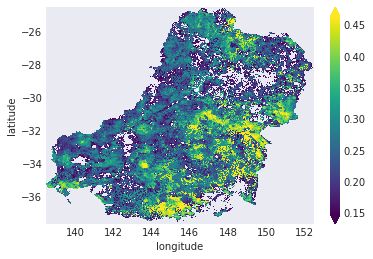

In [21]:
SIGNIFICANT = 0.05  # Choose your own!
corr_3M.pearson_r.where(corr_3M.pearson_p < SIGNIFICANT).plot.imshow(robust=True)


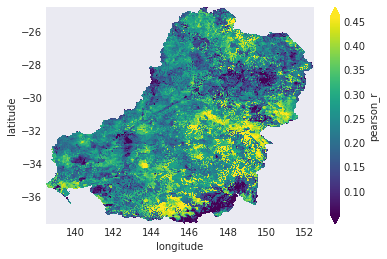

In [22]:
corr_3M.pearson_r.plot.imshow(robust=True)


In [20]:
# SAVE corelation matrix
path = '/g/data/oe9/project/team-drip/Spatial_temporal_correlation/SPI_NDVI/NDVI_SPI3M_Correlation.nc'
corr_3M.to_netcdf(path,mode = 'w')